# Part 1/2: Predicting whether a semiconductor product will pass or fail using machine learning approches

## Rylan Larsen

One useful data science approach in manufacturing is to make predictions about the pass/fail or quality of a product given sensor readouts from the manufacturing line. The SECOM dataset has a large number of such sensor readings and pass/fail labels for Semiconductor manufacturing. 

"The dataset presented in this case represents a selection of such features where each example represents a single production entity with associated measured features and the labels represent a simple pass/fail yield for in house line testing, figure 2, and associated date time stamp. Where –1 corresponds to a pass and 1 corresponds to a fail and the data time stamp is for that specific test point."

https://archive.ics.uci.edu/ml/datasets/secom


### Data Cleaning, feature selection, and dealing with class imbalance
This data set has a large number of features, many columns that are missing almost all their data, and a class imbalance. To deal with this, I eliminated features that had >80% of their values missing. I then dealt with the Class Imbalance using the SMOTE method.

To select features, I combined features selected by high mutual information (filter method), recursive elimation (wrapper method), and Lasso (L1) feature selection (Embedded). I then combined the list of features from each of these approaches into a final list that can be used to test a model. "

### Classification
Next I added classifiers to the the Secom dataset. The goal here was to make a classifier which predicte the class (pass/fail) for the manufacturing product. In this dataset, there are very few failed examples. Therefore, I trained the various classifiers on the dataset after dealing with class imbalance, but then tested the performance on the original dataset (imbalanced classes). 

To select various hyperparameters for the classifiers, I used the grid search method. Using this and either Random forest, decision tree, or SVM, I achieved the best performance on test data using a decision tree (f1 score, positive class 0.98, negative class, 0.77). The classifier still lagged on the negative class due to their imbalance, but did really well on the positive cases. A dataset with more negative class examples (fails) would likely do better.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from imblearn.over_sampling import SMOTE 

from sklearn.tree import DecisionTreeClassifier 

from sklearn.linear_model import LinearRegression,Lasso, LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.feature_selection import RFE,SelectFromModel #Recursive Feature Elimination

from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,classification_report,roc_auc_score

from IPython.display import Image
import os

ModuleNotFoundError: No module named 'imblearn'

# Load Dataset and parse columns

In [2]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
names = ["feat" + str(x) for x in range(1, 591)]
secom_var = pd.read_csv(url, sep=" ", names=names, na_values = "NaN") 
 
 
url_l = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
secom_labels = pd.read_csv(url_l,sep=" ",names = ["class","date"],parse_dates = ["date"],na_values = "NaN")

In [3]:
secom = pd.merge(secom_var, secom_labels,left_index=True,right_index=True)

In [4]:
secom.describe()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,...,feat582,feat583,feat584,feat585,feat586,feat587,feat588,feat589,feat590,class
count,1561.000000,1560.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.000000,1558.000000,1565.000000,1565.000000,...,618.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,97.934373,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066,-0.867262
std,73.621787,80.407705,29.513152,441.691640,56.355540,0.0,6.237214,0.008961,0.073897,0.015116,...,87.520966,0.003404,0.017180,0.003720,3.578033,0.012358,0.008808,0.002867,93.891919,0.498010
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,-1.000000
25%,2966.260000,2452.247500,2181.044400,1081.875800,1.017700,100.0,97.920000,0.121100,1.411200,-0.010800,...,46.184900,0.497900,0.011600,0.003100,2.306500,0.013425,0.010600,0.003300,44.368600,-1.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,-1.000000
75%,3056.650000,2538.822500,2218.055500,1591.223500,1.525700,100.0,104.586700,0.123800,1.516900,0.008400,...,116.539150,0.502375,0.016500,0.004100,3.295175,0.027600,0.020300,0.006400,114.749700,-1.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


In [5]:
print(np.shape(secom))

(1567, 592)


# Handle missing

There are a lot of attributes in this data set, let's explore how many of them have missing values:

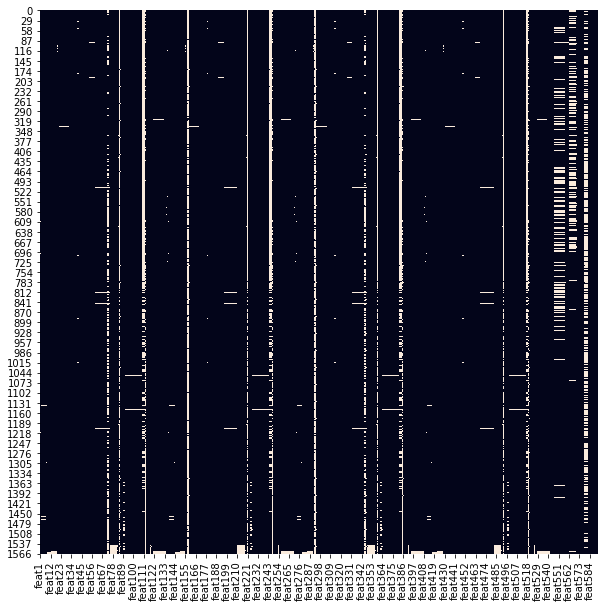

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(secom.isnull(), cbar=False,ax=ax);

Several of the columns are missing data the vast majority of the time. While we could encode the "missing" value as it's own type of variable for our feature selection, I'm going to remove features that are lacking more than 80% of their missing values and for the others, replace the misssing values by the median.

In [7]:
def replace_nan(df,cols,method='median',drop_columns_thresh=0.):
    '''Replace nan values in select pandas dataframe columns
    :Param df: dataframe to replace nans from
    :Param columns: columns to replace nans from
    :Param method: whether to use median or mean
    '''

    if drop_columns_thresh > 0.:
        if drop_columns_thresh > 1.:
            raise ('drop columns threshold is a percentage, cannot be greater than 1')
        
        drop_cols=list(df.columns[df.isnull().mean() > drop_columns_thresh])
        df.drop(drop_cols, axis=1)
        
    if method=='median':
        return df[cols].fillna(df.median())
    elif method=='mean':
        return df[cols].fillna(df.mean())
    

In [8]:
#get the columns of the dataframe
cols=list(secom.columns)
secom=replace_nan(secom,cols,drop_columns_thresh=0.8)
cols.remove('class')
cols.remove('date')


In [9]:
secom.describe()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,...,feat582,feat583,feat584,feat585,feat586,feat587,feat588,feat589,feat590,class
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.0,1567.000000,1567.000000,1567.000000,1567.000000,...,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,3014.441551,2495.866110,2200.551958,1395.383474,4.171281,100.0,101.116476,0.121825,1.462860,-0.000842,...,82.403069,0.500096,0.015317,0.003846,3.067628,0.021458,0.016474,0.005283,99.652345,-0.867262
std,73.480841,80.228143,29.380973,439.837330,56.103721,0.0,6.209385,0.008936,0.073849,0.015107,...,56.348694,0.003403,0.017174,0.003719,3.576899,0.012354,0.008805,0.002866,93.864558,0.498010
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.000000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000,-1.000000
25%,2966.665000,2452.885000,2181.099950,1083.885800,1.017700,100.0,97.937800,0.121100,1.411250,-0.010800,...,72.288900,0.497900,0.011600,0.003100,2.306500,0.013450,0.010600,0.003300,44.368600,-1.000000
50%,3011.490000,2499.405000,2201.066700,1285.214400,1.316800,100.0,101.512200,0.122400,1.461600,-0.001300,...,72.288900,0.500200,0.013800,0.003600,2.757650,0.020500,0.014800,0.004600,71.900500,-1.000000
75%,3056.540000,2538.745000,2218.055500,1590.169900,1.518800,100.0,104.530000,0.123800,1.516850,0.008400,...,72.288900,0.502350,0.016500,0.004100,3.294950,0.027600,0.020300,0.006400,114.749700,-1.000000
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,737.304800,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800,1.000000


Now that the missing values have been replaced, I want to try and understand how many of these attributes might be relevant to predicting the "class" for this dataset. To do this, I'm going to plot a heatmap of the correlation of each attribute with the class

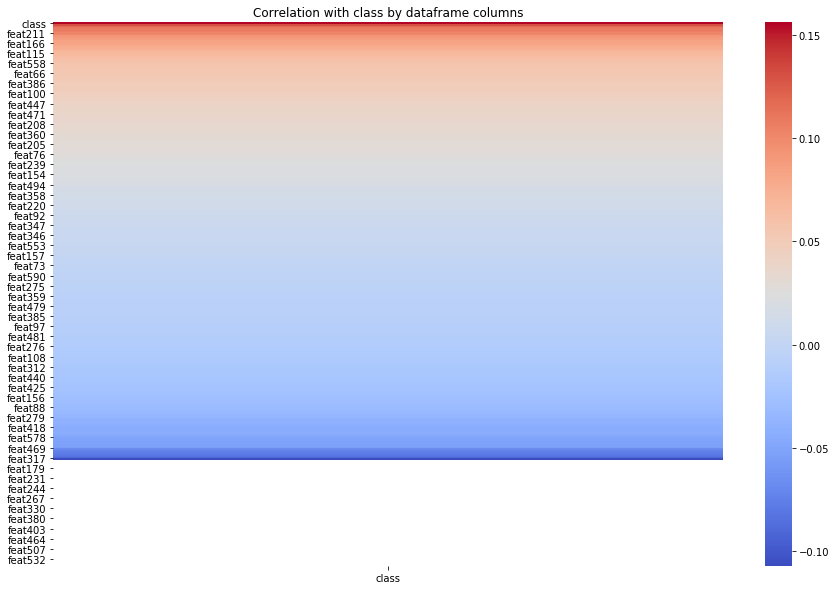

In [10]:
def corr_heatmap_by_class(df,class_to_corr,dims = (15, 10),annotate=False):
    corr=df.corr()
    fig, ax = plt.subplots(figsize=dims)

    ordered=corr[[class_to_corr]].sort_values(by=[class_to_corr],ascending=False)
    vmax=float(ordered.iloc[[1]].values)
    ax.set_title('Correlation with ' + str(class_to_corr) + ' by dataframe columns')

    return(sns.heatmap(ordered,cmap='coolwarm',vmax=vmax,annot=annotate,ax=ax))

corr_heatmap_by_class(secom,class_to_corr='class')

# Deal with Class Imbalance

In [11]:
#the label we are trying to identify is class
labels=secom['class']
feature_vecs=secom[cols]

In [12]:
#run SMOTE
X,y=feature_vecs,labels    
    
print('Original dataset shape {}'.format(Counter(y)))

sm = SMOTE('not majority',random_state=42)
X_res, y_res = sm.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({-1: 1463, 1: 104})
Resampled dataset shape Counter({-1: 1463, 1: 1463})


# Feature Selection

For Feature Selection, I'm going to use a combination of Filter methods, wrapper methods, and embedded methods to remove many of the least relevant features. At the end, I would like to have a subset of features that were selected by each method.

In [13]:
def calc_MI(x, y, bins):
    from sklearn.metrics import mutual_info_score
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [14]:
def cols_with_mut_info (df, cols,target_column, num_cols=11):
    '''Return the X (num_cols) number of columns that have the highest mutual information with a target attribute (column) 
    :Param df: dataframe containing columns to calculate mutual information from
    :Param target_columns: the target column for mutual information comparison (str)
    :Param method: whether to use median or mean
    '''
    from collections import OrderedDict
    items= {}
    for col in cols:
        items[col]=calc_MI(x=df[col], y=df[target_column],bins= num_cols)

    sorted_x = OrderedDict(sorted(items.items(), key=lambda kv: kv[1]))
    items=list(sorted_x.items())[::-1]

    return [items[x][0] for x in range(num_cols)]

In [15]:
high_mut_info=cols_with_mut_info(df=secom,cols=cols,target_column='class')
#pop off the target atrribute since it will have the highest mutual information
high_mut_info.pop(0)
print('Features with highest mutual information: ' + str(high_mut_info))

Features with highest mutual information: ['feat104', 'feat65', 'feat39', 'feat131', 'feat66', 'feat511', 'feat211', 'feat122', 'feat406', 'feat46']


## Wrapper methods

Sequential forward selection of features is too time consuming on this data due to the number of features (590). Therefore to help in feature selection, we ran recursive feature elimination.

In [16]:
#note that we are running this on the RESAMPLED DATA
estimator = LinearRegression()
selector = RFE(estimator, 10, step=1)#select 10 features. Step=1 means each step only remove 1 variable from the model
selector_resample = selector.fit(X_res, y_res)
#print(selector.support_) # The mask of selected features.
#print(selector.ranking_) # selected features are ranked 1. The 6th is the one that is removed first,
                         # 2nd is the one that is removed last
    
recursive_features=[X.columns[backs] for backs in list(np.where(selector_resample.ranking_==1)[0])]    
#print hte attribute names found for recursive feature elimination
print(recursive_features)

['feat35', 'feat37', 'feat96', 'feat102', 'feat148', 'feat173', 'feat175', 'feat283', 'feat308', 'feat310']


From this wrapper method, we get 10 attributes that we will add to our list of attributes to include in the model

# Embedded Method ( L1)

In [17]:

sel_ = SelectFromModel(LogisticRegression(C=0.05, penalty='l1',n_jobs=4))
sel_.fit(X_res, y_res)

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SelectFromModel(estimator=LogisticRegression(C=0.05, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='warn',
                                             n_jobs=4, penalty='l1',
                                             random_state=None, solver='warn',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [18]:
selected_feat = X.columns[(sel_.get_support())]

print('total features: {}'.format((X.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 590
selected features: 160
features with coefficients shrank to zero: 430


In [19]:
#print the removed features
removed_feats = X.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
print("Removed Features:")
removed_feats

Removed Features:


Index(['feat5', 'feat6', 'feat8', 'feat9', 'feat10', 'feat11', 'feat12',
       'feat13', 'feat14', 'feat17',
       ...
       'feat576', 'feat579', 'feat580', 'feat581', 'feat583', 'feat584',
       'feat585', 'feat587', 'feat588', 'feat589'],
      dtype='object', length=430)

# Combine Features from all methods

In [20]:
#Selected features combined from all methods (duplicates removed)

first_two=high_mut_info+list(set(recursive_features) - set(high_mut_info))

#good features is a set of features that includes highest mutual information, those selected by recursive elimination, 
#and those selected by L1 feature removal
good_features=first_two+list(set(selected_feat)-set(first_two))

In [21]:
print ('Total number of features after Feature Selection ' + str(np.shape(good_features)[0]))

Total number of features after Feature Selection 176


# Milestone 2 - Decision Tree, SVM, Ensemble Methods on above dataset

## Decision Tree

For the various models, I will train on the dataset with the features select below AND which have dealt with the class imbalance. For testing (test data), I will evaluate on the orginal, non-resampled data.

In [22]:
#resample the data to deal with class imbalance using on ly the good features
X,y=secom[good_features],secom['class']   
    
print('Original dataset shape {}'.format(Counter(y)))

sm = SMOTE('not majority',random_state=42)
X_res, y_res = sm.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({-1: 1463, 1: 104})
Resampled dataset shape Counter({-1: 1463, 1: 1463})


In [23]:
#split the resampled and orginal data
from sklearn.model_selection import train_test_split 


X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size = 0.25, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

To optimize the decision tree, I used the GridSearchCV option to find the best parameters

In [24]:
from sklearn.model_selection import GridSearchCV
    
hyper_parameters = {'min_samples_split':[2,5,15,20], 'max_depth':[5,7,12,15,30],
                    'max_features':('auto','sqrt','log2'), 'max_leaf_nodes':[15,20,30,45,60,70]}

dtc = DecisionTreeClassifier()
clf_dc = GridSearchCV(dtc, hyper_parameters, scoring='f1',cv=4, iid = False, return_train_score=True,n_jobs=5)
clf_dc.fit(X_train_res, y_train_res)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid=False, n_jobs=5,
             param_grid={'max_depth': [5, 7, 12, 15, 30],
                         'max_features': ('auto', 'sqrt', 'log2'),
               

In [25]:
print(classification_report(clf_dc.predict(X_test), y_test))

              precision    recall  f1-score   support

          -1       0.90      0.98      0.94       337
           1       0.69      0.33      0.44        55

    accuracy                           0.89       392
   macro avg       0.80      0.65      0.69       392
weighted avg       0.87      0.89      0.87       392



In [26]:
#print best parameters based on test score
clf_dc_params=pd.DataFrame(clf_dc.cv_results_)
print(list(clf_dc_params.loc[clf_dc_params['rank_test_score']==1]['params']))

[{'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': 60, 'min_samples_split': 20}]


In [27]:

#create a visualization of the tree -- must install graphviz and pydot2 packages for this to work

model_gini = DecisionTreeClassifier(max_depth=30,max_leaf_nodes=70,min_samples_split=2,max_features= 'sqrt')
model_gini.fit(X_train, y_train)
y_gini_pred = model_gini.predict(X_test)

y_train_gini_pred = model_gini.predict(X_train)

from sklearn import tree
dotfile = open("dtree_m2.dot", 'w')
tree.export_graphviz(model_gini, out_file = dotfile, feature_names = good_features)
dotfile.close()

#Convert the dot file to a png

os.system("dot -Tpng dtree_m2.dot -o dtree_m2.png")

0

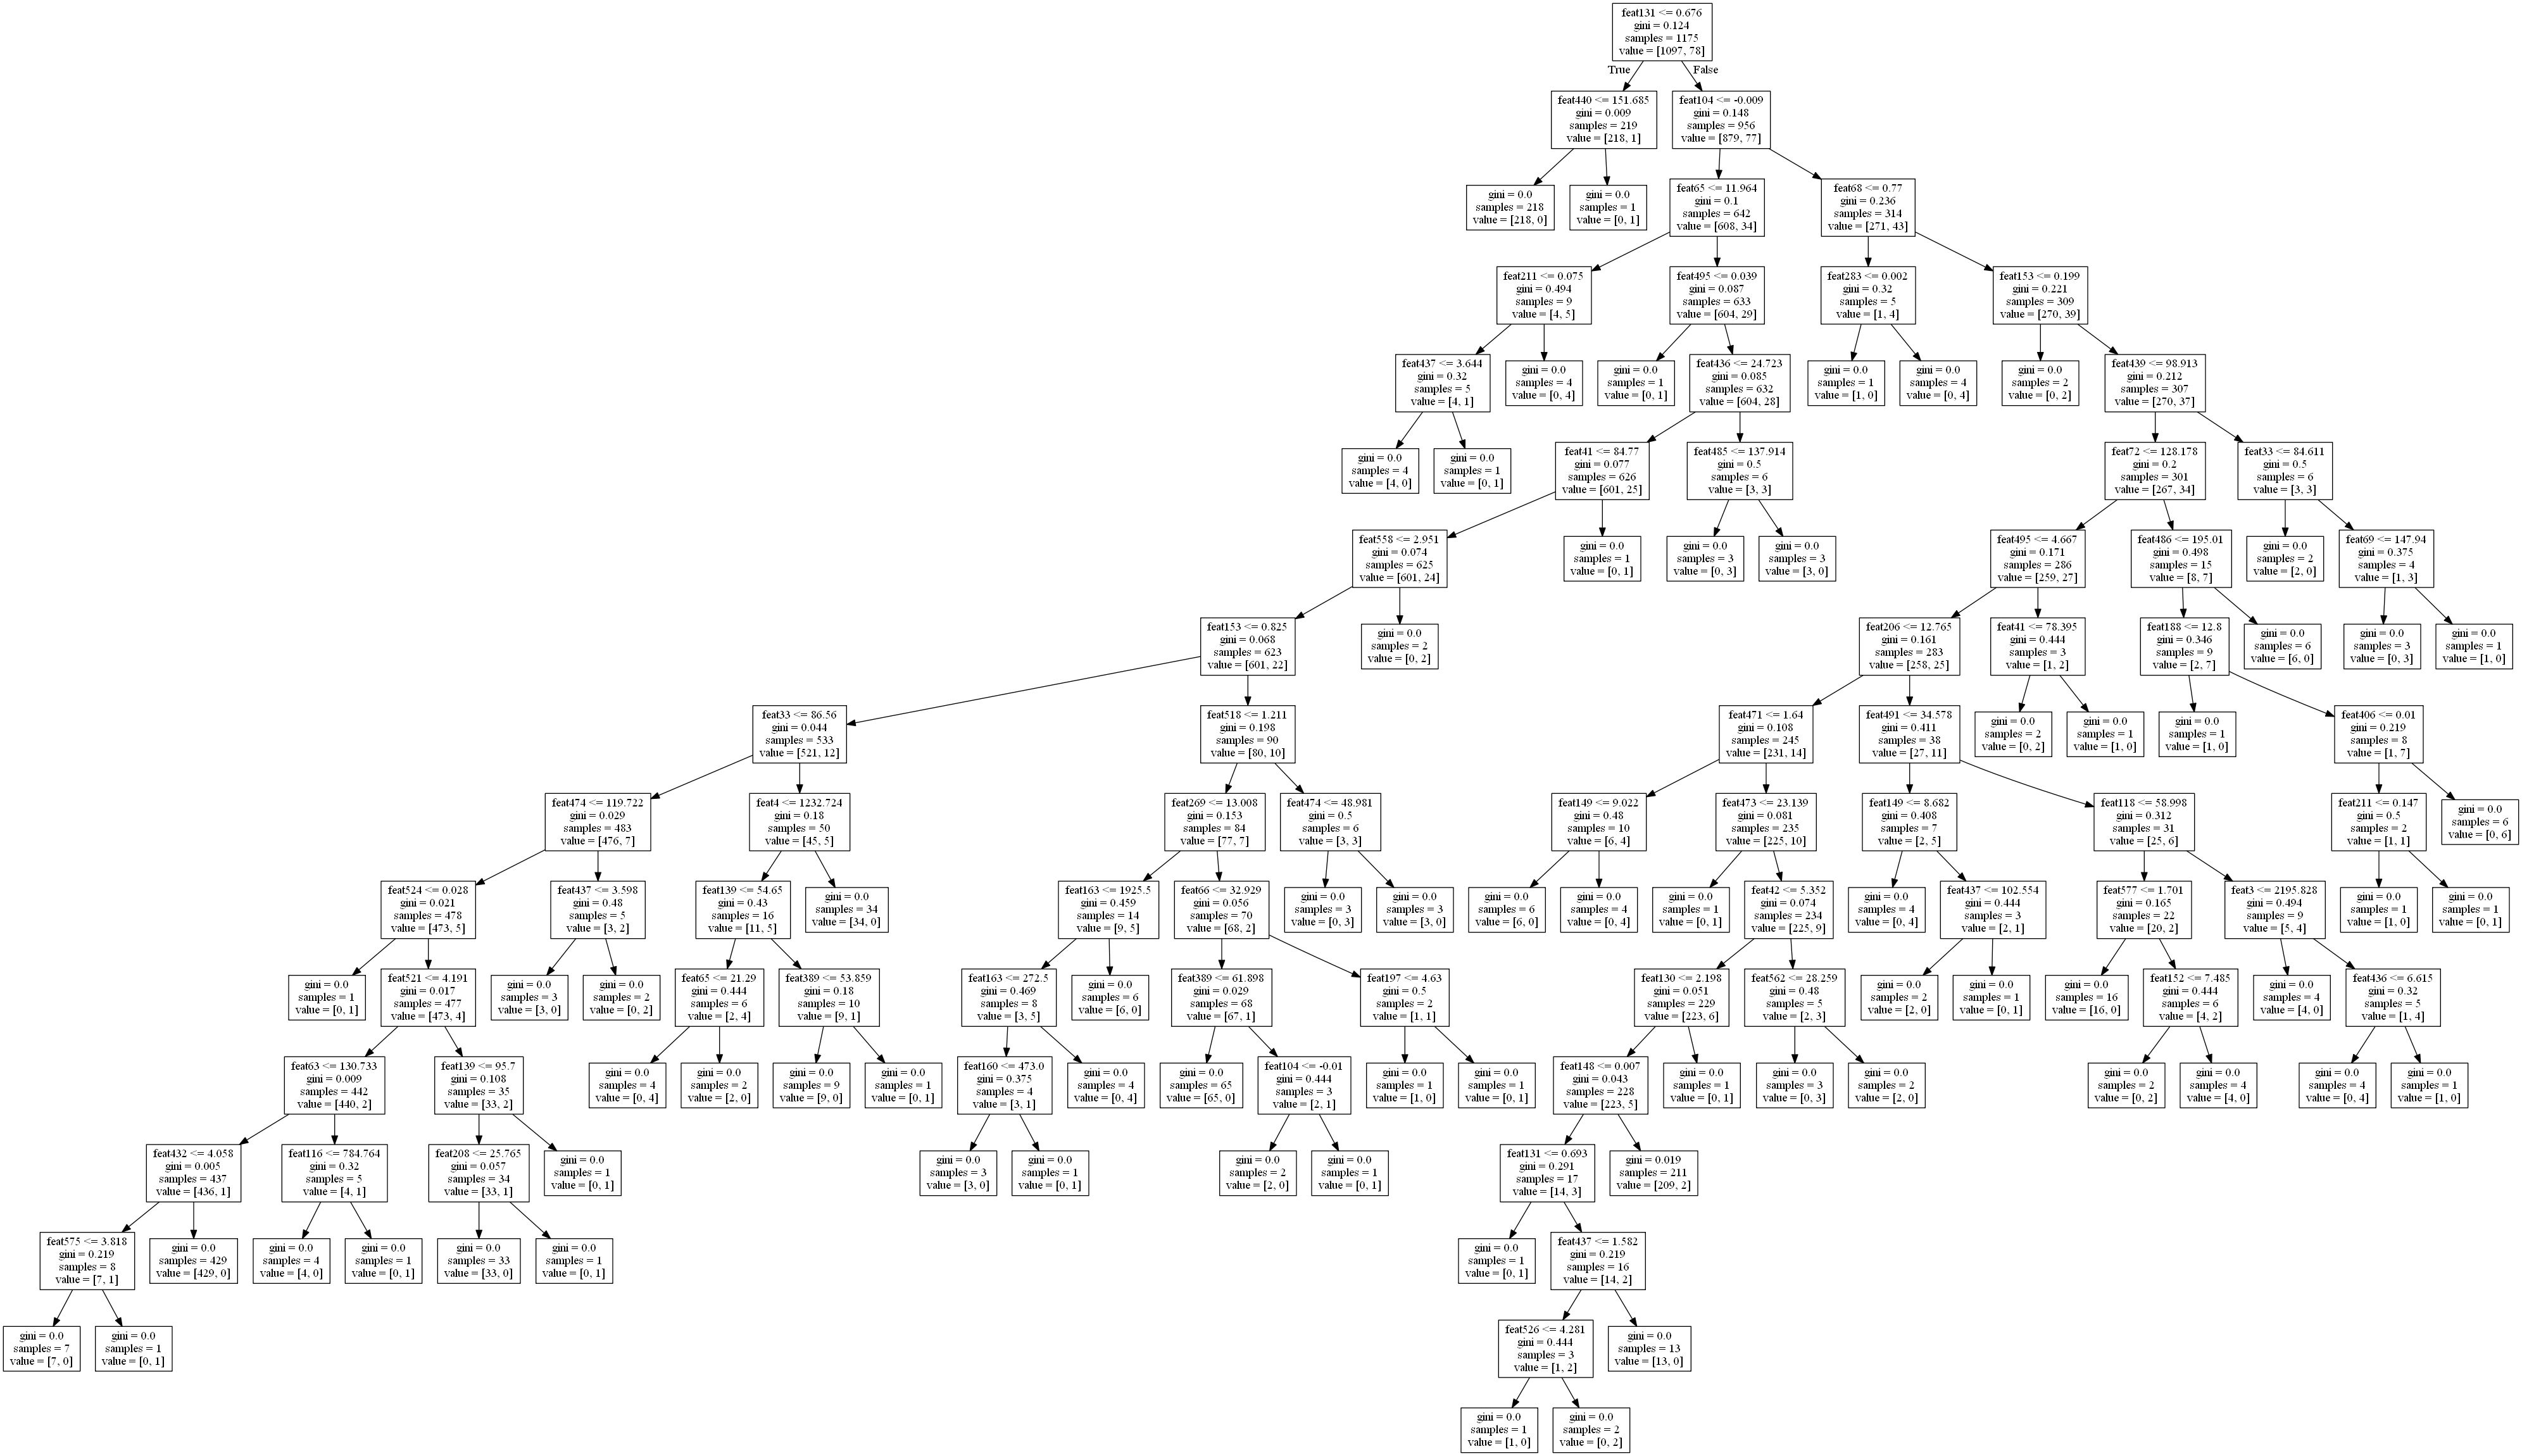

In [28]:
Image(filename='dtree_m2.png', width=1000, height=1000) 

## Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

hyper_parameters = {'n_estimators':[100,200], 'max_depth':[7,15,30,50],
                    'min_samples_leaf':[15,30,45], 'max_leaf_nodes':[15,45,60]}

rfc = RandomForestClassifier()
rfc_clf = GridSearchCV(rfc,hyper_parameters, scoring='f1',cv=2, iid = False, return_train_score=True,n_jobs=7)
rfc_clf.fit(X_train_res, y_train_res)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [30]:
#print the performance using hte best parameters
print(classification_report(rfc_clf.predict(X_test), y_test))

              precision    recall  f1-score   support

          -1       0.97      0.99      0.98       360
           1       0.85      0.69      0.76        32

    accuracy                           0.96       392
   macro avg       0.91      0.84      0.87       392
weighted avg       0.96      0.96      0.96       392



In [31]:
#print hte best parameters as defined by grid search
randfor_params=pd.DataFrame(rfc_clf.cv_results_)
print(list(randfor_params.loc[randfor_params['rank_test_score']==1]['params']))

[{'max_depth': 50, 'max_leaf_nodes': 45, 'min_samples_leaf': 15, 'n_estimators': 100}]


## Support Vector machines

Once again, I used the gridsearch function to identify the best hyper parameters, this time for hte SVM approach.

In [34]:
from sklearn import svm

In [ ]:
#note that this cell can take over an hour to run!

    
hyper_parameters = {'C':[1],'kernel':('linear', 'rbf', 'poly')}
svc = svm.SVC(gamma="scale")
clf = GridSearchCV(svc, hyper_parameters, cv=2, iid = False, return_train_score=False,n_jobs=8)
clf.fit(X_train_res, y_train_res)

In [ ]:
#print the performance using hte best parameters
print(classification_report(clf.predict(X_test), y_test))

In [ ]:
#print best parameters based on test score
svm_params=pd.DataFrame(clf.cv_results_)
print(list(svm_params.loc[svm_params['rank_test_score']==1]['params']))

# Direct comparison of hte three models

To directly compare the three optimized models above, I will rerun them with optimized parameters (decided from gridsearch) and then calculate a cross validation score for accuracy and precision. 

In [35]:
from sklearn import model_selection
models = []
models.append(('Dec_tree', DecisionTreeClassifier(max_depth=30,max_leaf_nodes=70,min_samples_split=2,max_features= 'sqrt')))
models.append(('Ran_for', RandomForestClassifier(max_depth=7, max_leaf_nodes=60, min_samples_leaf= 15, n_estimators=200 )))
models.append(('SVM', svm.SVC(C=1, kernel='linear')))


Dec_tree: 0.864936 (0.045391)
Ran_for: 0.933782 (0.025734)
SVM: 0.859936 (0.050657)


[Text(0, 0, 'Dec_tree'), Text(0, 0, 'Ran_for'), Text(0, 0, 'SVM')]

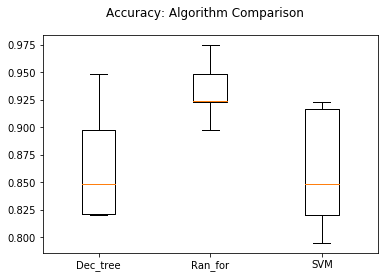

In [36]:

results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=3)
    cv_results = model_selection.cross_val_score(model, X_test, y_test, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Accuracy: Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)



Dec_tree: 0.079804 (0.012791)
Ran_for: 0.227098 (0.097449)
SVM: 0.084669 (0.016629)


[Text(0, 0, 'Dec_tree'), Text(0, 0, 'Ran_for'), Text(0, 0, 'SVM')]

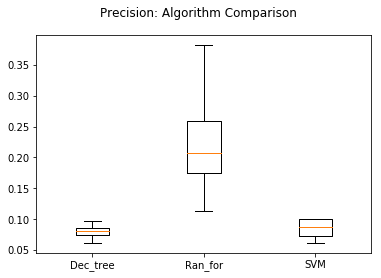

In [40]:
results = []
names = []
scoring = 'average_precision'
for name, model in models:
    kfold = model_selection.KFold(n_splits=4, random_state=3)
    cv_results = model_selection.cross_val_score(model, X_test, y_test, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Precision: Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)